In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import sys
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')

from keras.utils import to_categorical
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import itertools
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

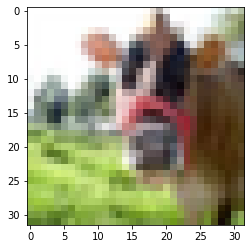

In [3]:
def show(img):
    img = img.reshape((32,32,3))
    plt.imshow(img)
    plt.show()

show(X_train[0])

# Image Preprocessing

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255
X_test = X_test / 255

In [5]:
# Centering
X_train = X_train - X_train.mean(axis=0)
X_test = X_test - X_test.mean(axis=0)

X_train -= X_train.mean(axis=0)
X_test -= X_test.mean(axis=0)

In [6]:
# Encoding label data
y_train_one_hot = to_categorical(y_train, 100)
y_test_one_hot = to_categorical(y_test, 100)

# Building Model

In [7]:
def create_model():
    # Create Neural Network
    cnn_clf = Sequential()
    cnn_clf.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
    cnn_clf.add(BatchNormalization())
    cnn_clf.add(Activation('elu'))
    cnn_clf.add(Conv2D(32, (3, 3), padding='same'))
    cnn_clf.add(Activation('elu'))
    cnn_clf.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_clf.add(Dropout(0.5))

    cnn_clf.add(Conv2D(64, (5, 5), padding='same'))
    cnn_clf.add(BatchNormalization())
    cnn_clf.add(Activation('elu'))
    cnn_clf.add(Conv2D(64, (5, 5), padding='same'))
    cnn_clf.add(BatchNormalization())
    cnn_clf.add(Activation('elu'))
    cnn_clf.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_clf.add(Dropout(0.5))

    cnn_clf.add(Conv2D(128, (5, 5), padding='same'))
    cnn_clf.add(BatchNormalization())
    cnn_clf.add(Activation('elu'))
    cnn_clf.add(Conv2D(128, (5, 5), padding='same'))
    cnn_clf.add(BatchNormalization())
    cnn_clf.add(Activation('elu'))
    cnn_clf.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_clf.add(Dropout(0.5))

    cnn_clf.add(Flatten())
    cnn_clf.add(Dense(1024, kernel_initializer='normal'))
    cnn_clf.add(BatchNormalization())
    cnn_clf.add(Activation('elu'))
    cnn_clf.add(Dropout(0.5))
    cnn_clf.add(Dense(100, activation='softmax'))
    return cnn_clf

In [8]:
create_model().summary()








_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
___

# K fold Cross Validation

In [9]:
def load_data_kfold(k):
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(X_train, y_train))
    return folds, X_train, y_train

k = 10

folds, X_train, y_train = load_data_kfold(k)

In [10]:
mean_accuracy_list = []
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_one_hot_cv = y_train_one_hot[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_one_hot_cv= y_train_one_hot[val_idx]
    cnn_clf = create_model()
    cnn_clf.compile(loss='categorical_crossentropy',
                    optimizer= 'adadelta',
                    metrics=['accuracy'])
    
    cnn_hist = cnn_clf.fit(X_train_cv, y_train_one_hot_cv, 
                           batch_size=64, epochs=30, 
                           validation_data=(X_valid_cv, y_valid_one_hot_cv),
                           shuffle=True)
    mean_accuracy_list.append(cnn_clf.evaluate(X_valid_cv, y_valid_one_hot_cv)[1])


Fold  0

Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 20s 433us/step - loss: 4.1277 - acc: 0.1015 - val_loss: 4.2201 - val_acc: 0.1014
Epoch 2/30
45000/45000 [==============================] - 17s 370us/step - loss: 3.3021 - acc: 0.2071 - val_loss: 2.9939 - val_acc: 0.2540
Epoch 3/30
45000/45000 [==============================] - 17s 371us/step - loss: 2.9069 - acc: 0.2774 - val_loss: 2.7842 - val_acc: 0.3154
Epoch 4/30
45000/45000 [==============================] - 17s 372us/step - loss: 2.6691 - acc: 0.3226 - val_loss: 2.7317 - val_acc: 0.3308
Epoch 5/30
45000/45000 [==============================] - 17s 372us/step - loss: 2.5075 - acc: 0.3551 - val_loss: 2.3912 - val_acc: 0.3810
Epoch 6/30
45000/45000 [==============================] - 17s 372us/step - loss: 2.3786 - acc: 0.3831 - val_loss: 2.2316 - val_acc: 0.4196
Epoch 7/30
45000/45000 [==============================] - 17s 372us/step - loss: 2.2819 - acc: 0.4020 - val

45000/45000 [==============================] - 17s 368us/step - loss: 1.5838 - acc: 0.5598 - val_loss: 1.6534 - val_acc: 0.5538
Epoch 25/30
45000/45000 [==============================] - 17s 369us/step - loss: 1.5636 - acc: 0.5655 - val_loss: 1.6736 - val_acc: 0.5490
Epoch 26/30
45000/45000 [==============================] - 17s 368us/step - loss: 1.5362 - acc: 0.5727 - val_loss: 1.6241 - val_acc: 0.5582
Epoch 27/30
45000/45000 [==============================] - 17s 370us/step - loss: 1.5178 - acc: 0.5751 - val_loss: 1.6065 - val_acc: 0.5604
Epoch 28/30
45000/45000 [==============================] - 17s 370us/step - loss: 1.4908 - acc: 0.5838 - val_loss: 1.5956 - val_acc: 0.5680
Epoch 29/30
45000/45000 [==============================] - 17s 370us/step - loss: 1.4742 - acc: 0.5853 - val_loss: 1.5809 - val_acc: 0.5700
Epoch 30/30
5000/5000 [==============================] - 1s 142us/step

Fold  4
Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [===================

45000/45000 [==============================] - 17s 374us/step - loss: 1.6618 - acc: 0.5424 - val_loss: 1.6743 - val_acc: 0.5434
Epoch 22/30
45000/45000 [==============================] - 17s 374us/step - loss: 1.6347 - acc: 0.5488 - val_loss: 1.6703 - val_acc: 0.5462
Epoch 23/30
45000/45000 [==============================] - 17s 374us/step - loss: 1.6071 - acc: 0.5532 - val_loss: 1.6375 - val_acc: 0.5494
Epoch 24/30
45000/45000 [==============================] - 17s 374us/step - loss: 1.5777 - acc: 0.5602 - val_loss: 1.6594 - val_acc: 0.5538
Epoch 25/30
45000/45000 [==============================] - 17s 374us/step - loss: 1.5579 - acc: 0.5674 - val_loss: 1.6720 - val_acc: 0.5432
Epoch 26/30
45000/45000 [==============================] - 17s 375us/step - loss: 1.5394 - acc: 0.5726 - val_loss: 1.6684 - val_acc: 0.5550
Epoch 27/30
45000/45000 [==============================] - 17s 374us/step - loss: 1.5182 - acc: 0.5738 - val_loss: 1.6318 - val_acc: 0.5544
Epoch 28/30
45000/45000 [=======

45000/45000 [==============================] - 17s 380us/step - loss: 1.7487 - acc: 0.5211 - val_loss: 1.8988 - val_acc: 0.5016
Epoch 19/30
45000/45000 [==============================] - 17s 379us/step - loss: 1.7170 - acc: 0.5304 - val_loss: 1.8066 - val_acc: 0.5286
Epoch 20/30
45000/45000 [==============================] - 17s 377us/step - loss: 1.6923 - acc: 0.5350 - val_loss: 1.6404 - val_acc: 0.5554
Epoch 21/30
45000/45000 [==============================] - 17s 380us/step - loss: 1.6585 - acc: 0.5417 - val_loss: 1.6328 - val_acc: 0.5574
Epoch 22/30
45000/45000 [==============================] - 17s 378us/step - loss: 1.6340 - acc: 0.5473 - val_loss: 1.6370 - val_acc: 0.5484
Epoch 23/30
45000/45000 [==============================] - 17s 379us/step - loss: 1.6154 - acc: 0.5519 - val_loss: 1.7620 - val_acc: 0.5236
Epoch 24/30
45000/45000 [==============================] - 17s 378us/step - loss: 1.5882 - acc: 0.5592 - val_loss: 1.6022 - val_acc: 0.5682
Epoch 25/30
45000/45000 [=======

45000/45000 [==============================] - 17s 383us/step - loss: 1.8547 - acc: 0.4960 - val_loss: 1.7522 - val_acc: 0.5270
Epoch 16/30
45000/45000 [==============================] - 17s 384us/step - loss: 1.8218 - acc: 0.5054 - val_loss: 1.8552 - val_acc: 0.5046
Epoch 17/30
45000/45000 [==============================] - 17s 385us/step - loss: 1.7848 - acc: 0.5146 - val_loss: 1.8048 - val_acc: 0.5110
Epoch 18/30
45000/45000 [==============================] - 17s 382us/step - loss: 1.7585 - acc: 0.5198 - val_loss: 1.7694 - val_acc: 0.5294
Epoch 19/30
45000/45000 [==============================] - 17s 385us/step - loss: 1.7208 - acc: 0.5267 - val_loss: 1.6629 - val_acc: 0.5458
Epoch 20/30
45000/45000 [==============================] - 17s 385us/step - loss: 1.6936 - acc: 0.5336 - val_loss: 1.6993 - val_acc: 0.5386
Epoch 21/30
45000/45000 [==============================] - 17s 383us/step - loss: 1.6706 - acc: 0.5408 - val_loss: 1.6645 - val_acc: 0.5476
Epoch 22/30
45000/45000 [=======

In [11]:
print('Average accuracy of the model is: {}%.'.format(float(np.mean(mean_accuracy_list))*100))

Average accuracy of the model is: 56.46%.


# Final Model

In [12]:
cnn_clf = create_model()
cnn_clf.compile(loss='categorical_crossentropy',
                optimizer= 'adadelta',
                metrics=['accuracy'])

cnn_hist = cnn_clf.fit(X_train, y_train_one_hot, 
                       batch_size=64, epochs=100, 
                       validation_data=(X_test, y_test_one_hot),
                       shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 23s 468us/step - loss: 4.0628 - acc: 0.1109 - val_loss: 3.4036 - val_acc: 0.1924
Epoch 2/100
50000/50000 [==============================] - 20s 390us/step - loss: 3.1905 - acc: 0.2243 - val_loss: 2.8073 - val_acc: 0.2910
Epoch 3/100
50000/50000 [==============================] - 20s 391us/step - loss: 2.8178 - acc: 0.2923 - val_loss: 2.5427 - val_acc: 0.3475
Epoch 4/100
50000/50000 [==============================] - 20s 391us/step - loss: 2.6003 - acc: 0.3338 - val_loss: 2.3800 - val_acc: 0.3803
Epoch 5/100
50000/50000 [==============================] - 20s 392us/step - loss: 2.4508 - acc: 0.3679 - val_loss: 2.3710 - val_acc: 0.3796
Epoch 6/100
50000/50000 [==============================] - 20s 391us/step - loss: 2.3346 - acc: 0.3902 - val_loss: 2.1067 - val_acc: 0.4429
Epoch 7/100
50000/50000 [==============================] - 20s 405us/step - loss: 2.2483 - acc: 0.4096 - val_l

Epoch 59/100
50000/50000 [==============================] - 19s 387us/step - loss: 1.0916 - acc: 0.6797 - val_loss: 1.4516 - val_acc: 0.6127
Epoch 60/100
50000/50000 [==============================] - 19s 386us/step - loss: 1.0769 - acc: 0.6831 - val_loss: 1.4811 - val_acc: 0.6096
Epoch 61/100
50000/50000 [==============================] - 19s 388us/step - loss: 1.0679 - acc: 0.6847 - val_loss: 1.4643 - val_acc: 0.6191
Epoch 62/100
50000/50000 [==============================] - 19s 386us/step - loss: 1.0687 - acc: 0.6854 - val_loss: 1.4516 - val_acc: 0.6158
Epoch 63/100
50000/50000 [==============================] - 19s 386us/step - loss: 1.0630 - acc: 0.6865 - val_loss: 1.5339 - val_acc: 0.6019
Epoch 64/100
50000/50000 [==============================] - 19s 386us/step - loss: 1.0430 - acc: 0.6928 - val_loss: 1.4495 - val_acc: 0.6213
Epoch 65/100
50000/50000 [==============================] - 19s 386us/step - loss: 1.0399 - acc: 0.6924 - val_loss: 1.4422 - val_acc: 0.6197
Epoch 66/100


# Classification Report

In [13]:
# Calculate accuracy for final model
y_pred = cnn_clf.predict(X_test)
pred = []
for i in range(y_test.shape[0]):
    pred.append(y_pred[i].argmax())
y_pred = np.array(pred)
y_test = y_test.flatten()
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)
print(classification_report(y_test, y_pred))

Accuracy:  0.6255
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       100
           1       0.81      0.71      0.76       100
           2       0.54      0.41      0.47       100
           3       0.46      0.32      0.38       100
           4       0.45      0.46      0.45       100
           5       0.65      0.53      0.58       100
           6       0.69      0.74      0.71       100
           7       0.64      0.67      0.66       100
           8       0.78      0.80      0.79       100
           9       0.76      0.78      0.77       100
          10       0.55      0.54      0.54       100
          11       0.53      0.37      0.44       100
          12       0.61      0.75      0.68       100
          13       0.67      0.55      0.60       100
          14       0.75      0.47      0.58       100
          15       0.64      0.65      0.65       100
          16       0.71      0.65      0.68       100
         

# Accuracy Graph

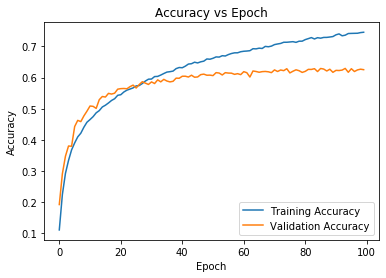

In [14]:
plt.plot(cnn_hist.history['acc'])
plt.plot(cnn_hist.history['val_acc'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

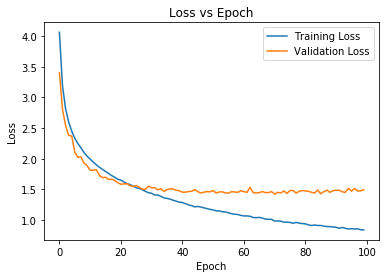

In [15]:
#Visualize the models loss
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Confusion Matrix

In [16]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.plasma):
    plt.figure(figsize = (15,13))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(len(classes))
    y_tick_marks = np.arange(-0.5, len(classes))
    plt.xticks(x_tick_marks, classes)
    plt.yticks(y_tick_marks, classes)
    plt.tick_params(axis='x', labelsize=7, labelrotation=45)
    plt.tick_params(axis='y', labelsize=7, labelrotation=45)
    thresh = cm.max() / 2
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], '.0f'), ha ='center', va ='center', 
#                  color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

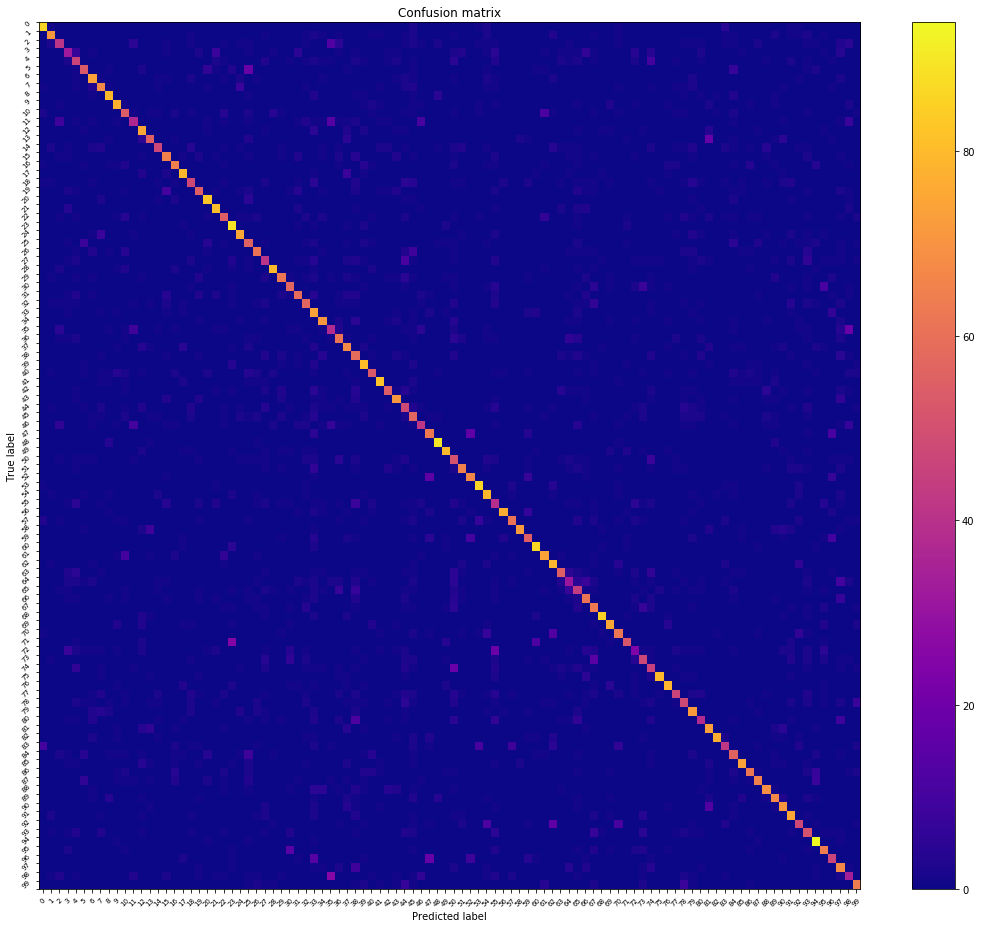

In [17]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=list(set(y_test)),
                      title='Confusion matrix')